In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import get_file
import numpy as np

# Define the base URL and filename for CelebA dataset
base_url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
file_name = 'celeba.zip'

# Download the CelebA dataset zip file
path = get_file(file_name, base_url, extract=False)

# Load the images from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/')  # Extract the zip file to a specific directory

# Define the directory path where the images are extracted
data_dir = '/content/img_align_celeba/'

# Load images using TensorFlow's load_img function
images = []
for i in range(1, 202599):  # Assuming the dataset contains 202,599 images
    file_path = data_dir + f'{i:06d}.jpg'  # File naming convention in CelebA dataset
    img = load_img(file_path)
    img = img.resize((64, 64))  # Resize the images to desired size
    img = np.array(img)
    images.append(img)

# Convert the list of images into a numpy array
images = np.array(images)

# Perform any additional preprocessing as needed
# (e.g., normalization, data augmentation, etc.)

# Now, you can use the 'images' numpy array as your input data for image reconstruction using VAEs in your Colab notebook without storing the data locally on your machine.


1443490838/1443490838 [==============================] - 26s 0us/step


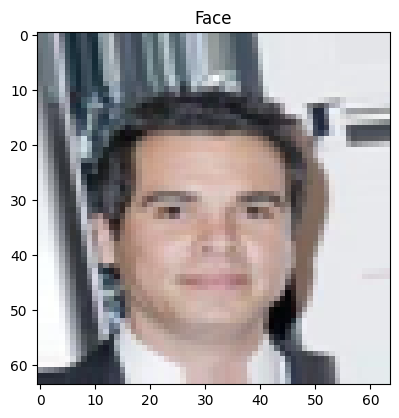

In [ ]:
import matplotlib.pyplot as plt
face_idx = np.random.randint(0, 202599)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(images[face_idx])
plt.title("Face"); plt.grid(False)